# Mode detection in MOs test

## Test 1: UniDip

### A: On a classic bimodal Gaussian

(4, 2)


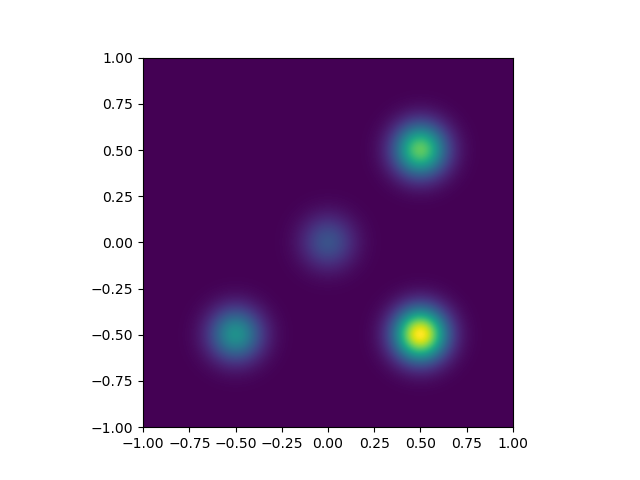

[125 374]
[250]
[374]


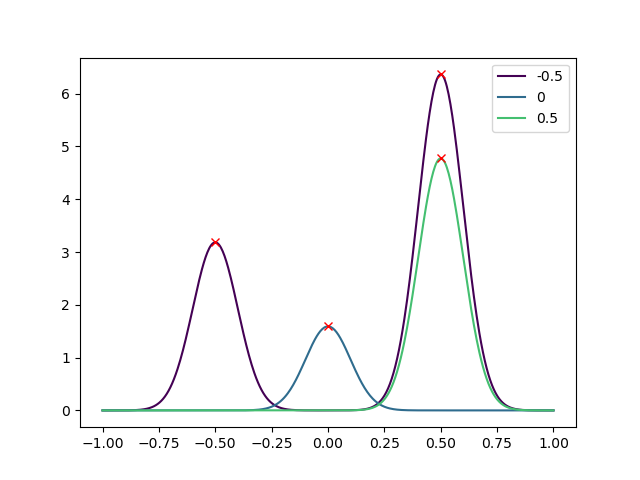

In [3]:
from scipy.signal import find_peaks, find_peaks_cwt

def multivar_gaussian(mu, sigma, XX, YY):
    return np.exp( -((XX - mu[0])**2  + (YY-mu[1])**2)/(2*sigma) ) / (2*np.pi*np.sqrt(sigma))

X = np.linspace(-1,1,500)
Y = np.linspace(-1,1,500)

XX, YY = np.meshgrid(X,Y,sparse=True)

sigma = 0.01

mu1 = np.array([0,0])
mu2 = np.array([-0.5,-0.5])
mu3 = np.array([0.5,0.5])
mu4 = np.array([0.5,-0.5])

pos = np.vstack([mu1,mu2,mu3,mu4])
print(pos.shape)
psi =np.arange(1,5)



fig, ax = plt.subplots()

f = sum( (N*multivar_gaussian(mu,0.01,XX,YY) for (N,mu) in zip(psi,pos) ) )
#f+= np.random.normal(scale=0.5,size=f.shape) #add noise
ax.imshow(f, origin='lower', extent=[*X[[0,-1]], *Y[[0,-1]]])
plt.show()

nsamples = 5
#yslices = np.arange(0,f.shape[1],f.shape[1]//nsamples)
yvals = [-0.5, 0, 0.5]
cm = plt_utils.get_cm(yvals,'viridis')

fig, ax = plt.subplots()

for c,y in zip(cm,yvals):
    n = np.argmin(np.abs(Y-y))
    data = f[n,:]
    peak_inds,_ = find_peaks(data)
    #peak_inds = find_peaks_cwt(data,widths=np.linspace(0.005,0.02))
    print(peak_inds)
    ax.plot(Y,data,c=c,label=f'{y}')
    ax.plot(Y[peak_inds],data[peak_inds],"rx")
plt.legend()
plt.show()



## Step 2: Examining density distribution for various MOs

First, let's load all of the data

In [4]:
from os import path
from qcnico.coords_io import read_xsf
from qcnico.remove_dangling_carbons import remove_dangling_carbons


datadir = path.expanduser("~/Desktop/simulation_outputs/percolation/40x40")
posdir = path.join(datadir, "structures")

lbls = [f'bigMAC-{n}' for n in [2,3,5,6,7,9,10]]

rCC_MAC = 1.8

def getARPACKdata(datadir,lbls):
    edir = path.join(datadir,'eARPACK')
    Mdir = path.join(datadir,'MOs_ARPACK')
    ee = [np.load(path.join(edir,f'eARPACK_{lbl}.npy')) for lbl in lbls]
    MM = [np.load(path.join(Mdir,f'MOs_ARPACK_{lbl}.npy')) for lbl in lbls]
    return ee, MM

def get_pos(posdir,lbls):
    return [remove_dangling_carbons(read_xsf(path.join(posdir,f"{lbl}_relaxed.xsf"))[0],rCC_MAC) for lbl in lbls]
    


ee, MM = getARPACKdata(datadir,lbls)
posarrs = get_pos(posdir,lbls)

Pick a specific MO based (previoulsy plotted in `sanity_check.ipynb`) that we know is multimodal

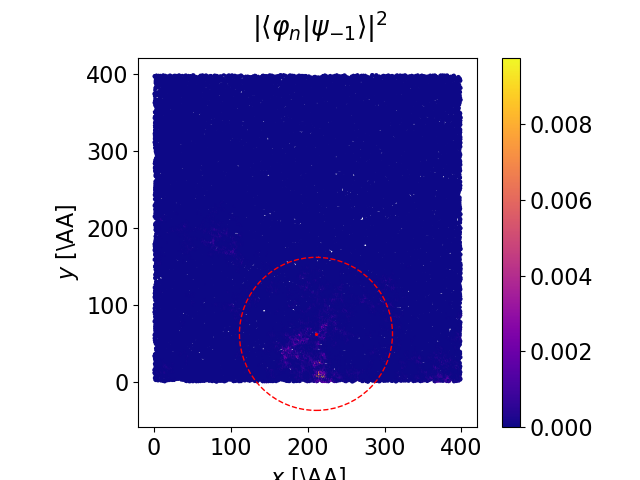

In [5]:
from qcnico.qcplots import plot_MO

istruc = 4 
iMO = -1 

pos = posarrs[istruc]
M = MM[istruc]

plot_MO(pos,M,iMO,dotsize=1.0,show_COM=True,show_rgyr=True,show=True,usetex=False)

[plt_utils.histogram] dx = 0.0008571941788386158
7.180376975239513e-09
57677


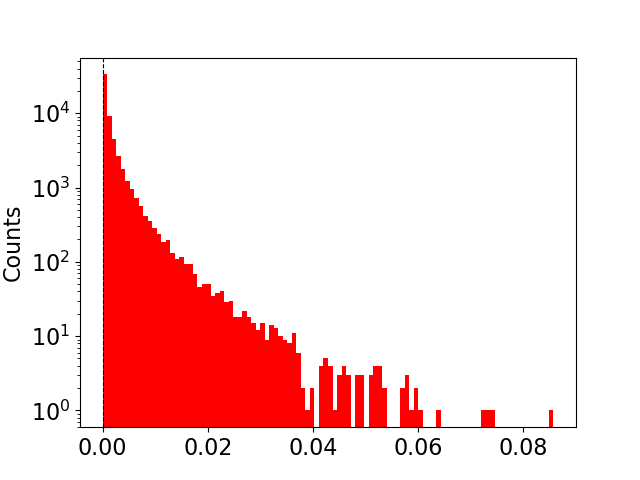

In [6]:
psi = np.abs(M[:,istruc])
eps = 1e-6
fig, ax = plt.subplots()
plt_utils.histogram(psi,nbins=100,log_counts=True, plt_objs=(fig,ax),show=False)
ax.axvline(x=eps,ymin=0, ymax=1, color='k', ls='--',lw=0.8)
print(np.min(psi))
print((psi>eps).sum())

(57779, 3)
(57779,)
(201, 201)
<class 'numpy.ndarray'>


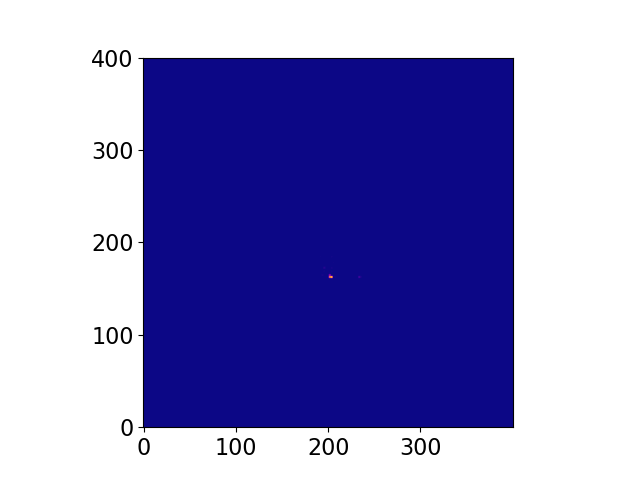

In [7]:
from qcnico.qchemMAC import gridify_MO

X = np.sort(pos[:,0])
Y = np.sort(pos[:,1])

deltaX = X[-1] - X[0]
deltaY = Y[-1] - Y[0]

res = 2.0 #resolution of grid in angstroms

xgrid = np.linspace(X[0]-deltaX*res, X[-1]+deltaX*res, int(deltaX/res)+1)
ygrid = np.linspace(Y[0]-deltaY*res, Y[-1]+deltaY*res, int(deltaY/res)+1)


XX, YY = np.meshgrid(xgrid,ygrid,sparse=True)

rho = gridify_MO(pos, M, iMO, XX, YY,eps=0)

print(type(rho)) 
fig, ax = plt.subplots()
ax.imshow(rho, cmap='plasma', origin='lower', extent=[*X[[0,-1]],*Y[[0,-1]]])
plt.show()

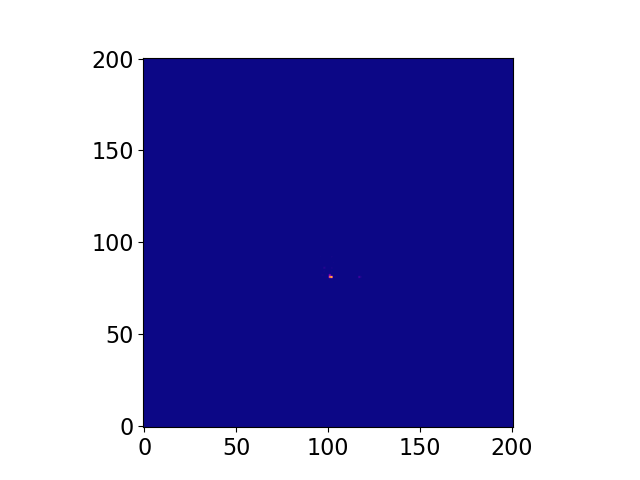

In [8]:
fig, ax = plt.subplots()
ax.imshow(rho, cmap='plasma', origin='lower') #, extent=[*X[[0,-1]],*Y[[0,-1]]])
plt.show()

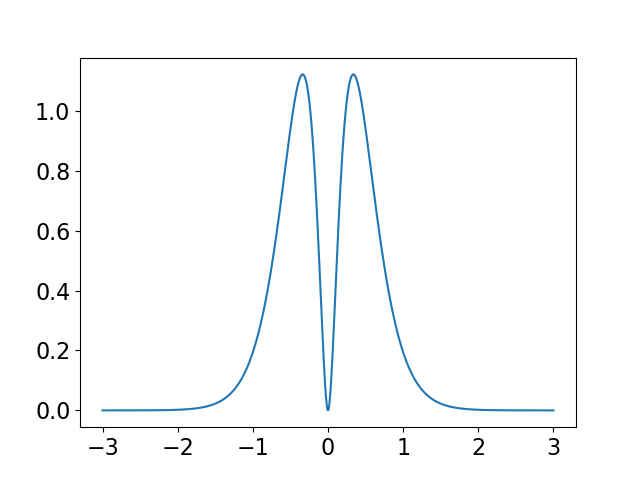

In [9]:
from qcnico.qchemMAC import slater_2pz

r = np.zeros(2)
z = np.linspace(-3,3,1000)

fig, ax = plt.subplots()

ax.plot(z,slater_2pz(r,0,0,z)**2)
plt.show()

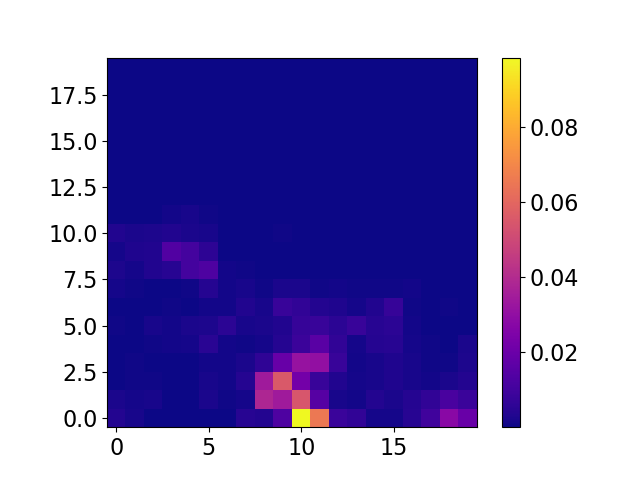

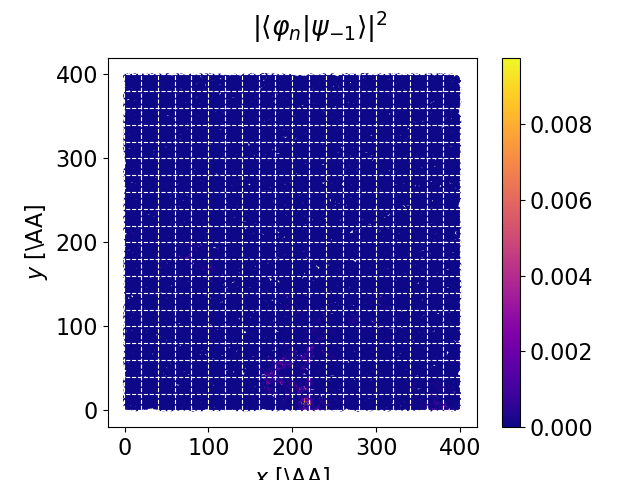

In [25]:
def gridifyMO3(pos,M,n,nbins,return_edges=True):
    x = pos.T[0]
    y = pos.T[1]
    psi = np.abs(M[:,n])**2
    #_, xedges, yedges = np.histogram2d(x,y,nbins)
    xedges = np.linspace(np.min(x)-0.1,np.max(x)+0.1,nbins+1,endpoint=True)
    yedges = np.linspace(np.min(y)-0.1,np.max(y)+0.1,nbins+1,endpoint=True)
    rho = np.zeros((nbins,nbins))
    for c, r in zip(psi,pos):
        x, y, _ = r
        i = np.sum(x > xedges) - 1
        j = np.sum(y > yedges) - 1
        rho[j,i] += c
    
    if return_edges:
        return rho, xedges, yedges
    else:
        return rho

rho, xedges, yedges = gridifyMO3(pos, M, iMO, 20)

#rho = rho[rho > ]

fig, ax = plt.subplots()
ye = ax.imshow(rho, cmap='plasma', origin='lower') #, extent=[*X[[0,-1]],*Y[[0,-1]]])
cbar = fig.colorbar(ye,ax=ax,orientation='vertical')
plt.show()


fig , ax = plt.subplots()
plot_MO(pos,M,iMO,dotsize=1.0,show=False,usetex=False, plt_objs=(fig,ax))
for (xe,ye) in zip(xedges,yedges):
    ax.axvline(x=xe,ymin=0,ymax=1,c='white',ls='--',lw=0.8)
    ax.axhline(y=ye,xmin=0,xmax=1,c='white',ls='--',lw=0.8)

cm = plt_utils.get_cm(range(20),'viridis',max_val=0.85)

    


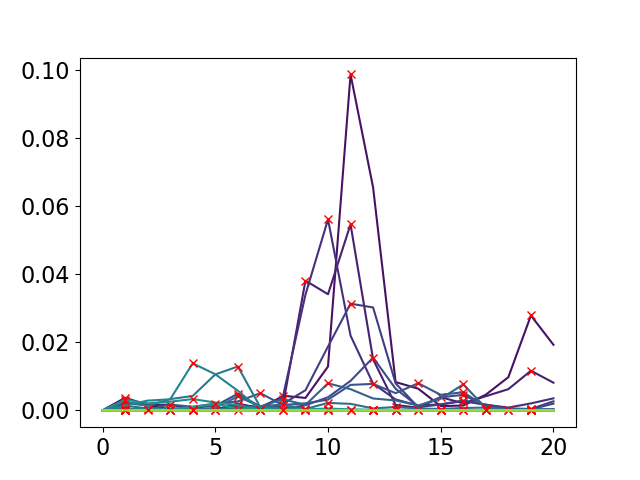

{(1, 11): 0.09864774030490767, (2, 9): 0.03810287720924423, (2, 11): 0.0546284909162595, (3, 10): 0.05608175789210756, (4, 11): 0.031327072468309285}


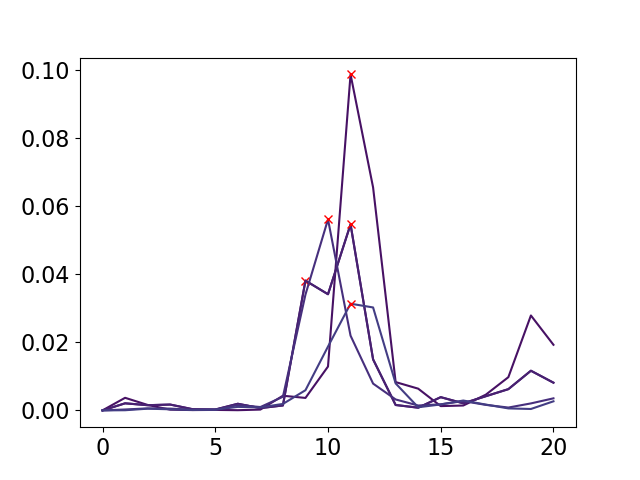

(1, 11): 0.09864774030490767
{(2, 11)}


(3, 10): 0.05608175789210756
{(2, 9), (4, 11), (2, 11)}


(2, 9): 0
set()


(4, 11): 0
set()


(2, 11): 0
set()


{(1, 11): 0.09864774030490767, (3, 10): 0.05608175789210756}


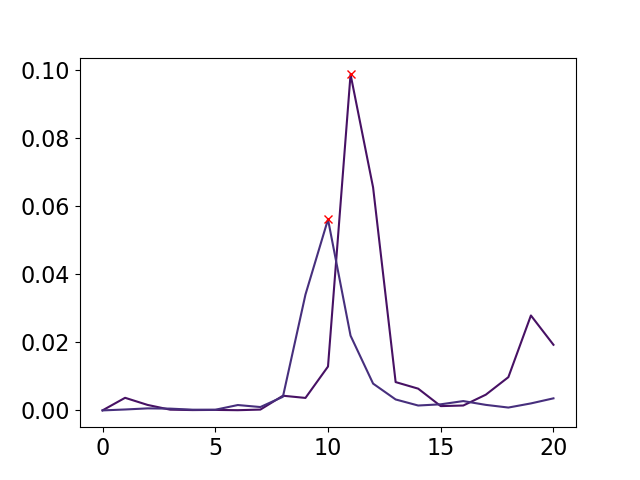

In [22]:
all_peaks = {}

fig, ax = plt.subplots()
for i in range(20):
    data = rho[i,:]
    ax.plot(data,c=cm[i])
    peak_inds, _ = find_peaks(data)
    #peaks_dat.append([[i,j, data[j]] for j in peak_inds])
    for j in peak_inds:
        peak_val = data[j]
        if peak_val > 1e-4: all_peaks[(i,j)] = peak_val
    ax.plot(peak_inds,data[peak_inds],'rx')
plt.show()

#max_peak = np.max(peaks[:,2])
#peaks = peaks[peaks[:,2] > 0.3*max_peak]
#print(peaks.shape)
threshold_ratio = 0.30
threshold = max(all_peaks.values())*threshold_ratio
peaks = {key:val for key,val in all_peaks.items() if val >= threshold}
print(peaks)

fig, ax = plt.subplots()
for ij in peaks.keys():
    #i,j,_ = pk.astype(int)
    i,j = ij
    data = rho[i,:]
    ax.plot(data,c=cm[i])
    ax.plot(j,data[j],'rx')
plt.show()

#pk_inds = set(tuple(ij) for ij in peaks[:,:2].astype(int))
pk_inds = set(peaks.keys())
shift = np.array([[0,1],[1,0],[1,1],[0,-1],[-1,0],[-1,-1],[1,-1],[-1,1]])


while pk_inds:
    ij = pk_inds.pop()
    print(f"{ij}: {peaks[ij]}")
    nns = set(tuple(nm) for nm in ij + shift)
    intersect = nns & pk_inds
    print(intersect)
    print('\n')
    for nm in intersect:
        peaks[nm] = 0


real_peaks = {key:val for key,val in peaks.items() if val > 0}

print(real_peaks)

fig, ax = plt.subplots()

for ij in real_peaks.keys():
    i,j = ij
    data = rho[i,:]
    ax.plot(data,c=cm[i])
    ax.plot(j,data[j],'rx')
plt.show()


        

        




In [29]:
def bin_centers(peak_inds,xedges,yedges):
    centers = np.zeros((len(peak_inds),2))
    for k, ij in enumerate(peak_inds):
        i,j = ij
        x = 0.5*(xedges[j]+xedges[j+1])
        y = 0.5*(yedges[i]+yedges[i+1])
        centers[k,:] = [x,y]
    return centers 

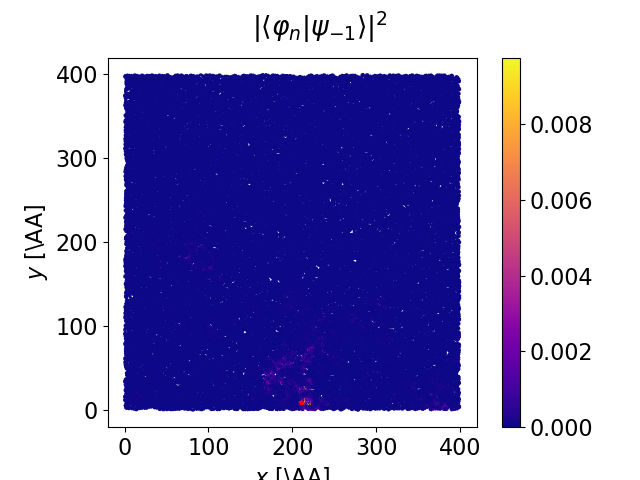

In [38]:
def get_MO_loc_centers(pos, M, n, nbins=20, threshold_ratio=0.60):
    rho, xedges, yedges = gridifyMO3(pos, M, n, nbins)

    all_peaks = {}
    for i in range(nbins):
        data = rho[i,:]
        peak_inds, _ = find_peaks(data)
        for j in peak_inds:
            peak_val = data[j]
            if peak_val > 1e-4: all_peaks[(i,j)] = peak_val

    threshold = max(all_peaks.values())*threshold_ratio
    peaks = {key:val for key,val in all_peaks.items() if val >= threshold}

    pk_inds = set(peaks.keys())
    shift = np.array([[0,1],[1,0],[1,1],[0,-1],[-1,0],[-1,-1],[1,-1],[-1,1]])


    while pk_inds:
        ij = pk_inds.pop()
        nns = set(tuple(nm) for nm in ij + shift)
        intersect = nns & pk_inds
        for nm in intersect:
            peaks[nm] = 0

    peak_inds = [key for key in peaks.keys() if peaks[key] > 0]

    return bin_centers(peak_inds,xedges,yedges)

n = 0

r0s = get_MO_loc_centers(pos,M,n)

fig, ax = plt.subplots()
plot_MO(pos,M,n,show=False,usetex=False,plt_objs=(fig,ax),dotsize=1.0)
ax.scatter(r0s.T[0],r0s.T[1],c='r' , marker='*', s=10.0)

plt.show()